In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/chest_xray.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: /c

# Setup (Colab) — installs, imports, and reproducibility

In [ ]:
# ===== Colab: one-time installs =====
!pip -q install --no-cache-dir timm==1.0.9 boruta==0.3 mrmr-selection==0.2.8 imbalanced-learn==0.12.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 134.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 145.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 221.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 402.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 284.2 MB/s eta 0:00:00


In [ ]:

# ===== Imports =====
import os, time, math, copy, random, json, gc, cv2, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as tvm
import timm  # for ConvNeXt / Swin

from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, matthews_corrcoef,
                             confusion_matrix, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_classif

from boruta import BorutaPy
from mrmr import mrmr_classif

import matplotlib.pyplot as plt



GPU & Colab free-tier

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
from pathlib import Path
DATA_DIR = Path("/content/chest_xray")
assert DATA_DIR.exists(), "Folder not found. Check unzip path."

splits, classes = ["train","val","test"], ["PNEUMONIA","NORMAL"]
for s in splits:
    for c in classes:
        p = DATA_DIR/s/c
        n = sum(len(list(p.glob(ext))) for ext in ("*.jpeg","*.jpg","*.png"))
        print(f"{s:5s}/{c:10s}: {n}")


train/PNEUMONIA : 3875
train/NORMAL    : 1341
val  /PNEUMONIA : 8
val  /NORMAL    : 8
test /PNEUMONIA : 390
test /NORMAL    : 234


In [ ]:
#  1) Point to your real dataset root
DATA_ROOT = Path('/content/chest_xray')   # <-- your folder

#  2) Choose where to save outputs
#    (A) Fast but temporary (lost when Colab resets):
# OUT = Path('/content/outputs')

#    (B) Persistent in Drive (uncomment to use):
OUT = Path('/content/drive/MyDrive/chest_xray_outputs')

# Create subfolders
OUT.mkdir(exist_ok=True, parents=True)
(OUT/'features').mkdir(exist_ok=True, parents=True)
(OUT/'plots').mkdir(exist_ok=True, parents=True)

print("DATA_ROOT =", DATA_ROOT)
print("OUT      =", OUT)

DATA_ROOT = /content/chest_xray
OUT      = /content/drive/MyDrive/chest_xray_outputs


# Preprocessing & Filtering (Resize, Normalize, Augment, Bilateral, CLAHE)

In [ ]:
# ===== Custom OpenCV filter transform =====
class XRayFilterTransform:
    def __init__(self, use_bilateral=True, use_clahe=True):
        self.use_bilateral = use_bilateral
        self.use_clahe = use_clahe
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) if use_clahe else None

    def __call__(self, img_pil):
        img = np.array(img_pil.convert('L'))  # to grayscale for x-rays
        if self.use_bilateral:
            # smooth noise while keeping edges (useful for bones/structures)
            img = cv2.bilateralFilter(img, d=5, sigmaColor=75, sigmaSpace=75)
        if self.use_clahe:
            # enhance local contrast in darker lung regions
            img = self.clahe.apply(img)
        return Image.fromarray(img).convert('RGB')  # back to 3-ch for pre-trained nets


Now define transforms:

In [ ]:
IMG_SIZE = 224  # works for AlexNet/ConvNeXt/Swin

train_tf = transforms.Compose([
    XRayFilterTransform(use_bilateral=True, use_clahe=True),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),        # Data Aug: Random Flip
    transforms.RandomResizedCrop(IMG_SIZE,        # Data Aug: Random Crop (with scale jitter)
                                scale=(0.9, 1.0), ratio=(0.98, 1.02)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

eval_tf = transforms.Compose([
    XRayFilterTransform(use_bilateral=True, use_clahe=True),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


Create loaders:

In [ ]:
batch_size = 16

train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, 'train'), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(DATA_ROOT, 'val'),   transform=eval_tf)
test_ds  = datasets.ImageFolder(os.path.join(DATA_ROOT, 'test'),  transform=eval_tf)

class_names = train_ds.classes  # ['NORMAL','PNEUMONIA'] or similar
num_classes = len(class_names)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(val_ds), len(test_ds), class_names


(5216, 16, 624, ['NORMAL', 'PNEUMONIA'])

# Feature Extractors (AlexNet, ConvNeXt-Tiny, Swin-Tiny) → 1024-ish dims

In [ ]:
# Helper: build backbone that returns a feature vector
def build_backbone(name):
    if name.lower() == 'alexnet':
        net = tvm.alexnet(weights=tvm.AlexNet_Weights.IMAGENET1K_V1)
        backbone = nn.Sequential(*list(net.features.children()),
                                 nn.AdaptiveAvgPool2d((1,1)),
                                 nn.Flatten())
        feat_dim = 256
    elif name.lower() == 'convnext_tiny':
        net = timm.create_model('convnext_tiny.in12k_ft_in1k', pretrained=True, num_classes=0, global_pool='avg')
        backbone = net  # outputs a pooled feature vector
        feat_dim = net.num_features
    elif name.lower() == 'swin_tiny':
        net = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=0, global_pool='avg')
        backbone = net
        feat_dim = net.num_features
    else:
        raise ValueError('Unknown backbone')
    return backbone.to(device).eval(), feat_dim

@torch.no_grad()
def extract_split_features(backbone, split_loader, amp=True):
    feats, labels = [], []
    scaler = torch.cuda.amp.autocast if (amp and device.type=='cuda') else torch.cpu.amp.autocast
    for xb, yb in split_loader:
        xb = xb.to(device, non_blocking=True)
        with scaler():
            fb = backbone(xb)
        feats.append(fb.float().cpu().numpy())
        labels.append(yb.numpy())
    return np.concatenate(feats), np.concatenate(labels)

def cache_features(model_name):
    cache_file = OUT/'features'/f'{model_name}_features.npz'
    if cache_file.exists():
        data = np.load(cache_file, allow_pickle=True)
        return (data['train_X'], data['train_y'],
                data['val_X'], data['val_y'],
                data['test_X'], data['test_y'])
    backbone, d = build_backbone(model_name)
    t0 = time.time()
    trX, trY = extract_split_features(backbone, train_loader)
    vaX, vaY = extract_split_features(backbone, val_loader)
    teX, teY = extract_split_features(backbone, test_loader)
    np.savez_compressed(cache_file, train_X=trX, train_y=trY, val_X=vaX, val_y=vaY, test_X=teX, test_y=teY, feat_dim=d)
    print(f'Cached {model_name} features in {(time.time()-t0):.1f}s. Shape: {trX.shape}')
    return trX, trY, vaX, vaY, teX, teY


In [ ]:
# Run for all
alex_trX, alex_trY, alex_vaX, alex_vaY, alex_teX, alex_teY = cache_features('alexnet')
conv_trX, conv_trY, conv_vaX, conv_vaY, conv_teX, conv_teY = cache_features('convnext_tiny')
swin_trX,  swin_trY,  swin_vaX,  swin_vaY,  swin_teX,  swin_teY  = cache_features('swin_tiny')


Cached alexnet features in 277.5s. Shape: (5216, 256)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Cached convnext_tiny features in 280.2s. Shape: (5216, 768)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Cached swin_tiny features in 278.2s. Shape: (5216, 768)


# *Metrics helper (ACC, SEN, SPE, MCC, PRE, F1, AUC) + timing*

In [ ]:
def compute_metrics(y_true, y_prob, thresh=0.5):
    y_pred = (y_prob >= thresh).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    sen = recall_score(y_true, y_pred)  # sensitivity = recall on positive class
    # specificity = TN / (TN+FP)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spe = tn / (tn + fp + 1e-12)
    f1  = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    return dict(AUC=auc, ACC=acc, SEN=sen, SPE=spe, MCC=mcc, PRE=pre, F1=f1)


# Train classic heads on features: RF, MLP

In [ ]:
# Reproducibility + constants (run this BEFORE rf_head/mlp_head are used)
import random, numpy as np, torch
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("SEED set to", SEED)


SEED set to 42


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

def rf_head():
    return RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    )

def mlp_head(input_dim):
    return MLPClassifier(
        hidden_layer_sizes=(512, 128),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        batch_size=128,
        max_iter=40,
        random_state=SEED,
        verbose=False
    )


Run for each feature set:

In [ ]:
results_table = []
probs_bank = {}  # for ensemble later

# AlexNet
m, p = train_eval_sklearn(rf_head(), alex_trX, alex_trY, alex_vaX, alex_vaY, alex_teX, alex_teY, 'RF');    results_table.append({'Feature':'AlexNet', **m}); probs_bank[('AlexNet','RF')]=p
m, p = train_eval_sklearn(mlp_head(alex_trX.shape[1]), alex_trX, alex_trY, alex_vaX, alex_vaY, alex_teX, alex_teY, 'MLP'); results_table.append({'Feature':'AlexNet', **m}); probs_bank[('AlexNet','MLP')]=p

# ConvNeXt
m, p = train_eval_sklearn(rf_head(), conv_trX, conv_trY, conv_vaX, conv_vaY, conv_teX, conv_teY, 'RF');    results_table.append({'Feature':'ConvNeXt', **m}); probs_bank[('ConvNeXt','RF')]=p
m, p = train_eval_sklearn(mlp_head(conv_trX.shape[1]), conv_trX, conv_trY, conv_vaX, conv_vaY, conv_teX, conv_teY, 'MLP'); results_table.append({'Feature':'ConvNeXt', **m}); probs_bank[('ConvNeXt','MLP')]=p

# Swin
m, p = train_eval_sklearn(rf_head(), swin_trX, swin_trY, swin_vaX, swin_vaY, swin_teX, swin_teY, 'RF');    results_table.append({'Feature':'Swin', **m}); probs_bank[('Swin','RF')]=p
m, p = train_eval_sklearn(mlp_head(swin_trX.shape[1]), swin_trX, swin_trY, swin_vaX, swin_vaY, swin_teX, swin_teY, 'MLP'); results_table.append({'Feature':'Swin', **m}); probs_bank[('Swin','MLP')]=p

df_table1 = pd.DataFrame(results_table)
df_table1


,Feature,AUC,ACC,SEN,SPE,MCC,PRE,F1,Training Time,Testing Time,Classifier
0,AlexNet,0.931208,0.766026,0.984615,0.401709,0.509832,0.732824,0.840263,36.826160,0.116206,RF
1,AlexNet,0.947913,0.809295,0.989744,0.508547,0.606389,0.770459,0.866442,13.601045,0.013602,MLP
2,ConvNeXt,0.930331,0.714744,0.987179,0.260684,0.390178,0.689964,0.812236,61.025381,0.116880,RF
3,ConvNeXt,0.957298,0.879808,0.989744,0.696581,0.750505,0.844639,0.911452,20.112778,0.008638,MLP
4,Swin,0.942439,0.705128,0.994872,0.222222,0.373812,0.680702,0.808333,68.725421,0.118583,RF
5,Swin,0.937125,0.833333,0.989744,0.572650,0.656028,0.794239,0.881279,15.358228,0.007666,MLP


# A small CNN (image-level) and an AttLSTM (sequence over patches)

`CNN baseline (end-to-end on images)`

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, n=2):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(128, n))
    def forward(self,x):
        return self.head(self.body(x))

def train_torch_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss = nn.CrossEntropyLoss()
    best, best_w = 0, copy.deepcopy(model.state_dict())
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
    t0 = time.time()
    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits = model(xb)
                l = loss(logits, yb)
            scaler.scale(l).backward()
            scaler.step(opt); scaler.update()
        # simple val acc
        model.eval(); corr=n=0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb,yb = xb.to(device), yb.to(device)
                pred = model(xb).argmax(1)
                corr += (pred==yb).sum().item(); n+=yb.size(0)
        acc = corr/n
        if acc>best: best, best_w = acc, copy.deepcopy(model.state_dict())
    train_time = time.time()-t0
    model.load_state_dict(best_w)
    return model, train_time

def predict_proba_torch(model, dl):
    model.eval(); ps=[]
    with torch.no_grad():
        for xb, _ in dl:
            xb = xb.to(device)
            p = model(xb).softmax(1)[:,1].cpu().numpy()
            ps.append(p)
    return np.concatenate(ps)


Train & evaluate:

In [ ]:
cnn_model, cnn_train_t = train_torch_model(SmallCNN(num_classes), train_loader, val_loader, epochs=6, lr=1e-3)
t1=time.time(); cnn_probs = predict_proba_torch(cnn_model, test_loader); cnn_test_t = time.time()-t1
cnn_metrics = compute_metrics(test_ds.targets if hasattr(test_ds,'targets') else np.array([y for _,y in test_ds.samples]), cnn_probs)
df_table1 = pd.concat([df_table1,
                       pd.DataFrame([{'Feature':'AlexNet', **{'Classifier':'CNN', **cnn_metrics, 'Training Time':cnn_train_t, 'Testing Time':cnn_test_t}}],
                                    )], ignore_index=True)


`Attention-LSTM on Swin patch features`

In [ ]:
class SwinTokens(nn.Module):
    def __init__(self):
        super().__init__()
        # returns spatial tokens, no pooling
        self.swin = timm.create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True, num_classes=0, global_pool=''
        )
        self.swin.eval()

    @torch.no_grad()
    def forward(self, x):
        y = self.swin(x)
        # timm Swin usually returns (B, H, W, C). Handle both cases safely.
        if y.ndim == 4:
            B, H, W, C = y.shape              # (B, H, W, C)
            y = y.reshape(B, H * W, C)        # (B, L, C)
        elif y.ndim == 3:
            # already (B, L, C)
            pass
        else:
            raise RuntimeError(f"Unexpected Swin output shape: {tuple(y.shape)}")
        return y


Train & evaluate:

In [ ]:
tok, att_model, att_train_t = train_attlstm(epochs=4, lr=1e-3)
t1=time.time(); att_probs = predict_attlstm(tok, att_model, test_loader); att_test_t = time.time()-t1
att_metrics = compute_metrics(test_ds.targets if hasattr(test_ds,'targets') else np.array([y for _,y in test_ds.samples]), att_probs)
df_table1 = pd.concat([df_table1,
                       pd.DataFrame([{'Feature':'Swin', **{'Classifier':'AttLSTM', **att_metrics, 'Training Time':att_train_t, 'Testing Time':att_test_t}}])],
                      ignore_index=True)


# Ensemble (Voting) for each feature family

In [36]:
def soft_vote(probs_list):
    return np.clip(np.mean(probs_list, axis=0), 1e-6, 1-1e-6)

ensemble_rows = []

# Per-feature ensembles (AlexNet/ConvNeXt/Swin) -> Voting
alex_vote = soft_vote([probs_bank[('AlexNet','RF')], probs_bank[('AlexNet','MLP')]])
alex_m = compute_metrics(alex_teY, alex_vote); alex_m.update({'Training Time': np.nan, 'Testing Time': np.nan, 'Classifier':'Voting'})
ensemble_rows.append({'Feature':'AlexNet', **alex_m})

conv_vote = soft_vote([probs_bank[('ConvNeXt','RF')], probs_bank[('ConvNeXt','MLP')]])
conv_m = compute_metrics(conv_teY, conv_vote); conv_m.update({'Training Time': np.nan, 'Testing Time': np.nan, 'Classifier':'Voting'})
ensemble_rows.append({'Feature':'ConvNeXt', **conv_m})

swin_vote = soft_vote([probs_bank[('Swin','RF')], probs_bank[('Swin','MLP')], att_probs])
swin_m = compute_metrics(swin_teY, swin_vote); swin_m.update({'Training Time': np.nan, 'Testing Time': np.nan, 'Classifier':'Voting'})
ensemble_rows.append({'Feature':'Swin', **swin_m})

df_table1 = pd.concat([df_table1, pd.DataFrame(ensemble_rows)], ignore_index=True)
df_table1.to_csv(OUT/'Table1_feature_vs_classifier.csv', index=False)
df_table1


,Feature,AUC,ACC,SEN,SPE,MCC,PRE,F1,Training Time,Testing Time,Classifier
0,AlexNet,0.931208,0.766026,0.984615,0.401709,0.509832,0.732824,0.840263,36.826160,0.116206,RF
1,AlexNet,0.947913,0.809295,0.989744,0.508547,0.606389,0.770459,0.866442,13.601045,0.013602,MLP
2,ConvNeXt,0.930331,0.714744,0.987179,0.260684,0.390178,0.689964,0.812236,61.025381,0.116880,RF
3,ConvNeXt,0.957298,0.879808,0.989744,0.696581,0.750505,0.844639,0.911452,20.112778,0.008638,MLP
4,Swin,0.942439,0.705128,0.994872,0.222222,0.373812,0.680702,0.808333,68.725421,0.118583,RF
5,Swin,0.937125,0.833333,0.989744,0.572650,0.656028,0.794239,0.881279,15.358228,0.007666,MLP
6,AlexNet,0.891661,0.810897,0.828205,0.782051,0.602902,0.863636,0.845550,1451.818549,29.138447,CNN
7,Swin,0.955829,0.844551,0.982051,0.615385,0.675324,0.809725,0.887601,983.489521,29.375858,AttLSTM
8,AlexNet,0.941716,0.807692,0.989744,0.504274,0.603046,0.768924,0.865471,NaN,NaN,Voting
9,ConvNeXt,0.951079,0.873397,0.989744,0.679487,0.737517,0.837310,0.907168,NaN,NaN,Voting


# Feature Selection on (say) the best extractor (choose one)

In [37]:
best_feat = df_table1.groupby('Feature')['AUC'].mean().sort_values(ascending=False).index[0]
best_map = {'AlexNet': (alex_trX, alex_trY, alex_vaX, alex_vaY, alex_teX, alex_teY),
            'ConvNeXt':(conv_trX, conv_trY, conv_vaX, conv_vaY, conv_teX, conv_teY),
            'Swin':    (swin_trX, swin_trY, swin_vaX, swin_vaY, swin_teX, swin_teY)}
trX, trY, vaX, vaY, teX, teY = best_map[best_feat]
X_all = np.concatenate([trX, vaX]); y_all = np.concatenate([trY, vaY])

# Convert to DataFrame for mRMR
df_all = pd.DataFrame(X_all); df_all['label'] = y_all.astype(int)



`RFE (with logistic regression proxy):`

In [38]:
from sklearn.linear_model import LogisticRegression
def select_rfe(X, y, k):
    base = LogisticRegression(max_iter=200, n_jobs=-1)
    rfe = RFE(base, n_features_to_select=k, step=0.1)  # remove 10% each step
    rfe.fit(X, y)
    return rfe.support_

k = 500
mask_rfe = select_rfe(X_all, y_all, k)


`ANOVA (SelectKBest)`

In [39]:
mask_anova = SelectKBest(score_func=f_classif, k=k).fit(X_all, y_all).get_support()


`mRMR (max-relevance min-redundancy)`

In [46]:
from mrmr import mrmr_classif
k = 500  # number of features you want
feat_names = [f'f{i}' for i in range(X_all.shape[1])]
df_tmp = pd.DataFrame(X_all, columns=feat_names)
y_tmp = pd.Series(y_all, name='label')

# mRMR selection returns a list of selected column names
selected_names = mrmr_classif(X=df_tmp, y=y_tmp, K=k)

# Build boolean mask in the same format as the other selectors
mask_mrmr = np.array([name in selected_names for name in feat_names], dtype=bool)

# (optional) sanity check
print('Selected:', mask_mrmr.sum(), 'features')

100%|██████████| 500/500 [02:38<00:00,  3.15it/s]

Selected: 500 features


`Boruta (wrapper around RF)`

In [48]:
# Provide missing aliases Boruta expects
if not hasattr(np, "int"):
    np.int = int
if not hasattr(np, "float"):
    np.float = float
if not hasattr(np, "bool"):
    np.bool = bool
print("NumPy shims in place:", [(a, hasattr(np, a)) for a in ["int","float","bool"]])

NumPy shims in place: [('int', True), ('float', True), ('bool', True)]


In [51]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(
    n_estimators=300,          # ↓ from 500
    random_state=SEED,
    n_jobs=-1,                 # use all CPU cores
    class_weight='balanced'
)

# smaller, faster Boruta
boruta = BorutaPy(
    rf,
    n_estimators='auto',
    perc=80,                   # slightly easier acceptance threshold
    max_iter=15,               # ↓ iterations (each iter fits a forest)
    random_state=SEED,
    verbose=2                  # show progress so you know it’s moving
)

# OPTIONAL: stratified subsample to speed up
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, train_size=min(3000, len(X_all)), random_state=SEED)
idx, _ = next(sss.split(X_all, y_all))
X_sub, y_sub = X_all[idx], y_all[idx]

boruta.fit(X_sub, y_sub)

bor_mask = boruta.support_
# If more than k accepted, keep top-k by Boruta ranking
if bor_mask.sum() > k:
    ranks = boruta.ranking_
    idx_sorted = np.argsort(ranks)[:k]
    mask_boruta = np.zeros_like(bor_mask); mask_boruta[idx_sorted] = True
else:
    mask_boruta = bor_mask


Iteration: 	1 / 15
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	2 / 15
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	3 / 15
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	4 / 15
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	5 / 15
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	6 / 15
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	7 / 15
Confirmed: 	0
Tentative: 	768
Rejected: 	0
Iteration: 	8 / 15
Confirmed: 	436
Tentative: 	332
Rejected: 	0
Iteration: 	9 / 15
Confirmed: 	436
Tentative: 	332
Rejected: 	0
Iteration: 	10 / 15
Confirmed: 	436
Tentative: 	332
Rejected: 	0
Iteration: 	11 / 15
Confirmed: 	436
Tentative: 	332
Rejected: 	0
Iteration: 	12 / 15
Confirmed: 	472
Tentative: 	296
Rejected: 	0
Iteration: 	13 / 15
Confirmed: 	472
Tentative: 	296
Rejected: 	0
Iteration: 	14 / 15
Confirmed: 	472
Tentative: 	296
Rejected: 	0


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	472
Tentative: 	175
Rejected: 	0


`Evaluate with 500 selected features (Table-2)`

In [52]:
def subset_and_eval(mask, name):
    trX_k, vaX_k, teX_k = trX[:,mask], vaX[:,mask], teX[:,mask]
    res=[]
    for clf_name, builder in [('RF', rf_head), ('MLP', lambda: mlp_head(trX_k.shape[1]))]:
        m, _ = train_eval_sklearn(builder(), trX_k, trY, vaX_k, vaY, teX_k, teY, clf_name + f' ({name})')
        res.append(m)
    return res

tab2_rows = []
for msk, nm in [(mask_rfe,'RFE'), (mask_anova,'Anova'), (mask_mrmr,'mRMR'), (mask_boruta,'Boruta')]:
    tab2_rows += subset_and_eval(msk, nm)

df_table2 = pd.DataFrame(tab2_rows)
df_table2.to_csv(OUT/'Table2_feature_selection_500.csv', index=False)
df_table2


,AUC,ACC,SEN,SPE,MCC,PRE,F1,Training Time,Testing Time,Classifier
0,0.928561,0.721154,0.992308,0.269231,0.411706,0.693548,0.816456,56.708267,0.128292,RF (RFE)
1,0.936369,0.810897,0.994872,0.504274,0.613142,0.769841,0.868009,16.693172,0.005783,MLP (RFE)
2,0.932396,0.703526,0.992308,0.222222,0.366345,0.680141,0.807091,63.490441,0.116622,RF (Anova)
3,0.930084,0.815705,0.989744,0.525641,0.619714,0.776660,0.870349,13.399384,0.005529,MLP (Anova)
4,0.932824,0.705128,0.994872,0.222222,0.373812,0.680702,0.808333,56.120329,0.174567,RF (mRMR)
5,0.940165,0.818910,0.989744,0.534188,0.626350,0.779798,0.872316,14.631624,0.015673,MLP (mRMR)
6,0.937629,0.709936,0.992308,0.239316,0.383242,0.684956,0.810471,50.439085,0.118835,RF (Boruta)
7,0.928972,0.810897,0.989744,0.512821,0.609728,0.772000,0.867416,13.743737,0.005611,MLP (Boruta)


`Vary feature count (200/300/500/700/900) using your best selector (Table-3)`

In [53]:
# choose best selector by AUC
best_selector_name = (df_table2.groupby('Classifier')['AUC'].mean().sort_values(ascending=False).index[0]).split()[-1].strip('()')
best_selector_name


'mRMR'

`Build a small helper to refit that selector for different K:`

In [55]:
# Try to use mrmr-selection (pure Python). If not present, we'll use the greedy fallback.
try:
    from mrmr import mrmr_classif
    _HAS_MRMR = True
except Exception as e:
    _HAS_MRMR = False
    print("mrmr-selection not available; will use greedy mRMR fallback.")

from sklearn.feature_selection import mutual_info_classif

def mrmr_greedy_mask(X, y, K, seed=42):
    """Fallback: MI - redundancy penalty (abs Pearson corr)."""
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=seed)
    Xn = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)
    corr = np.abs(np.corrcoef(Xn, rowvar=False))
    selected, remaining = [], list(range(X.shape[1]))
    for _ in range(min(K, X.shape[1])):
        best_j, best_score = None, -1e9
        for j in remaining:
            redundancy = np.mean([corr[j, s] for s in selected]) if selected else 0.0
            score = mi[j] - redundancy
            if score > best_score:
                best_score, best_j = score, j
        selected.append(best_j); remaining.remove(best_j)
    mask = np.zeros(X.shape[1], dtype=bool); mask[selected] = True
    return mask


In [56]:
def get_mask(selector, K):
    selector = selector.strip().replace('(greedy)','').replace('(mrmr)','').replace('(MRMR)','').replace('(mRMR)','mRMR')
    if selector in ['RFE','rfe']:
        return select_rfe(X_all, y_all, K)

    if selector.lower() in ['anova', 'f_classif']:
        return SelectKBest(f_classif, k=K).fit(X_all, y_all).get_support()

    if selector.lower() in ['mrmr', 'mRMR', 'MRMR']:
        if _HAS_MRMR:
            # mrmr-selection expects DataFrame with column names
            feat_names = [f'f{i}' for i in range(X_all.shape[1])]
            df_tmp = pd.DataFrame(X_all, columns=feat_names)
            y_tmp  = pd.Series(y_all, name='label')
            selected = mrmr_classif(X=df_tmp, y=y_tmp, K=K)
            mask = np.array([name in selected for name in feat_names], dtype=bool)
            return mask
        else:
            # fallback
            return mrmr_greedy_mask(X_all, y_all, K)

    if selector.lower() in ['boruta', 'boruta_py', 'boruta (rf)']:
        rf = RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1, class_weight='balanced')
        boruta = BorutaPy(rf, n_estimators='auto', random_state=SEED, verbose=0, max_iter=15)
        # (optional) small subsample to speed up
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, train_size=min(3000, len(X_all)), random_state=SEED)
        idx, _ = next(sss.split(X_all, y_all))
        boruta.fit(X_all[idx], y_all[idx])
        ranks = boruta.ranking_
        idx_sorted = np.argsort(ranks)[:K]
        mask = np.zeros(X_all.shape[1], dtype=bool); mask[idx_sorted] = True
        return mask

    raise ValueError(f'Unknown selector: {selector}')


In [58]:
rows = []
for K in [200, 300, 500, 700, 900]:
    maskK = get_mask(best_selector_name, K)
    for clf_name, builder in [
        ('RF', rf_head),
        ('MLP', lambda: mlp_head(trX[:, maskK].shape[1]))  # <-- use masked dim
    ]:
        m, _ = train_eval_sklearn(builder(), trX[:, maskK], trY, vaX[:, maskK], vaY, teX[:, maskK], teY, clf_name)
        rows.append({'Feature Count': K, **m})

df_table3 = pd.DataFrame(rows)
df_table3.to_csv(OUT/'Table3_feature_count_sweep.csv', index=False)
df_table3


100%|██████████| 768/768 [03:08<00:00,  4.08it/s]


,Feature Count,AUC,ACC,SEN,SPE,MCC,PRE,F1,Training Time,Testing Time,Classifier
0,200,0.934248,0.716346,0.992308,0.256410,0.399665,0.689840,0.813880,34.720793,0.137998,RF
1,200,0.936308,0.839744,0.994872,0.581197,0.671980,0.798354,0.885845,7.662849,0.003857,MLP
2,300,0.933974,0.708333,0.992308,0.235043,0.379065,0.683746,0.809623,41.395803,0.152998,RF
3,300,0.920984,0.801282,0.992308,0.482906,0.591382,0.761811,0.861915,8.146855,0.004499,MLP
4,500,0.932824,0.705128,0.994872,0.222222,0.373812,0.680702,0.808333,54.260573,0.117313,RF
5,500,0.940165,0.818910,0.989744,0.534188,0.626350,0.779798,0.872316,13.371087,0.005918,MLP
6,700,0.935125,0.705128,0.994872,0.222222,0.373812,0.680702,0.808333,66.466181,0.118366,RF
7,700,0.919395,0.823718,0.989744,0.547009,0.636274,0.784553,0.875283,15.749671,0.008414,MLP
8,900,0.942439,0.705128,0.994872,0.222222,0.373812,0.680702,0.808333,68.117967,0.116978,RF
9,900,0.937125,0.833333,0.989744,0.572650,0.656028,0.794239,0.881279,16.270609,0.007884,MLP


`Visualizations (ROC, bar, violin, line, radar)`

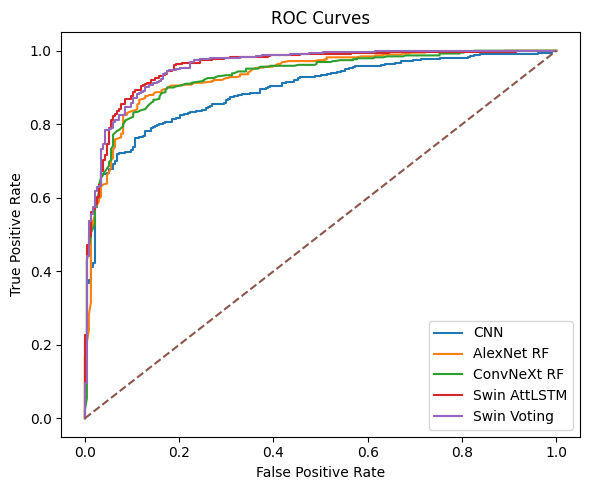

<Figure size 800x400 with 0 Axes>

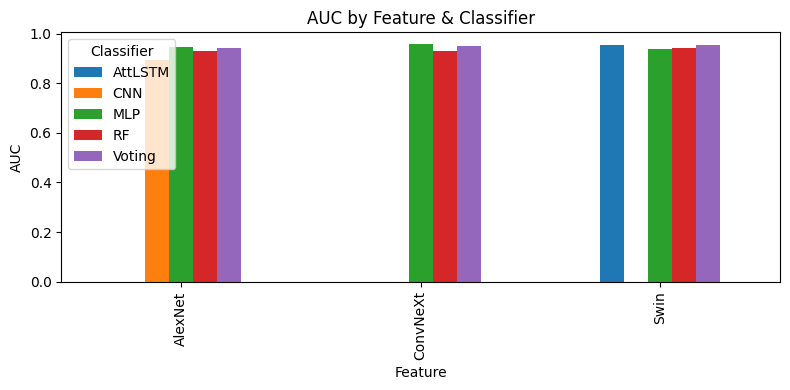

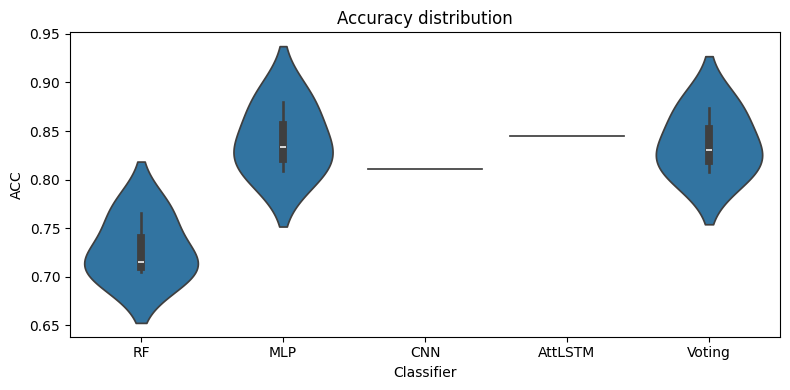

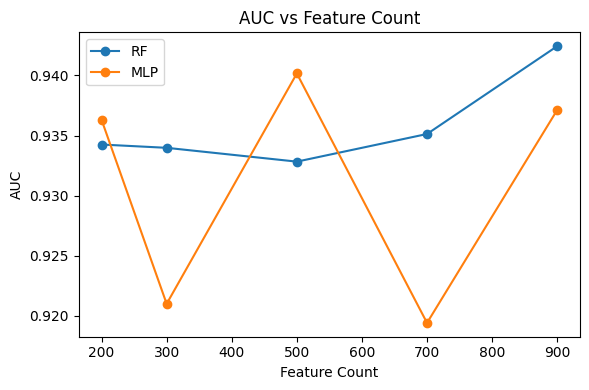

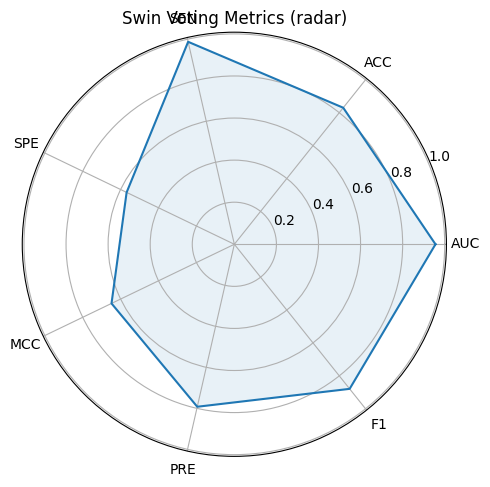

In [61]:
# ROC (must)
plt.figure(figsize=(6,5))
for label,(probs, ytrue) in [
    ('CNN', (cnn_probs, test_ds.targets)),
    ('AlexNet RF', (probs_bank[('AlexNet','RF')], alex_teY)),
    ('ConvNeXt RF', (probs_bank[('ConvNeXt','RF')], conv_teY)),
    ('Swin AttLSTM', (att_probs, swin_teY)),
    ('Swin Voting', (swin_vote, swin_teY)),
]:
    fpr,tpr,_ = roc_curve(ytrue, probs)
    plt.plot(fpr,tpr,label=label)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.legend(); plt.tight_layout(); plt.savefig(OUT/'plots/roc.png'); plt.show()

# Bar chart of AUC by (Feature, Classifier)
plt.figure(figsize=(8,4))
(df_table1.pivot_table(index='Feature', columns='Classifier', values='AUC')
 .plot(kind='bar', figsize=(8,4)))
plt.ylabel('AUC'); plt.title('AUC by Feature & Classifier'); plt.tight_layout()
plt.savefig(OUT/'plots/bar_auc.png'); plt.show()

# Violin plot of metrics distribution per classifier
import seaborn as sns
plt.figure(figsize=(8,4))
sns.violinplot(data=df_table1, x='Classifier', y='ACC')
plt.title('Accuracy distribution'); plt.tight_layout()
plt.savefig(OUT/'plots/violin_acc.png'); plt.show()

# Line chart: AUC vs Feature Count (Table 3)
plt.figure(figsize=(6,4))
for clf in df_table3['Classifier'].unique():
    d = df_table3[df_table3['Classifier']==clf].sort_values('Feature Count')
    plt.plot(d['Feature Count'], d['AUC'], marker='o', label=clf)
plt.xlabel('Feature Count'); plt.ylabel('AUC'); plt.title('AUC vs Feature Count')
plt.legend(); plt.tight_layout(); plt.savefig(OUT/'plots/line_auc_vs_k.png'); plt.show()

# Radar (radial) chart for one setting
def radar(metrics_dict, title, fname):
    labels = ['AUC','ACC','SEN','SPE','MCC','PRE','F1']
    values = [metrics_dict[k] for k in labels]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    values += values[:1]; angles += angles[:1]
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values); ax.fill(angles, values, alpha=0.1)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_title(title); plt.tight_layout(); plt.savefig(fname); plt.show()

radar(swin_m, 'Swin Voting Metrics (radar)', OUT/'plots/radar_swin_voting.png')


`Exporting your tables (as in the screenshots)`

In [63]:
# Make them look like your assignment tables
def pretty(df, fname):
    cols = ['Feature','Classifier','AUC','ACC','SEN','SPE','MCC','PRE','F1','Training Time','Testing Time']
    (df[cols] if set(cols).issubset(df.columns) else df).to_csv(OUT/fname, index=False)

pretty(df_table1, 'Table1_feature_vs_classifier.csv')
pretty(df_table2, 'Table2_select_500.csv')
pretty(df_table3, 'Table3_feature_count.csv')

print('Saved to:', OUT)


Saved to: /content/drive/MyDrive/chest_xray_outputs
